## 第十週：主題模型（中文）
Last modified: 蔡睿澤（2024/04/23） <br>

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
<br>
這次課程分為7個部分：
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. lexicon-based 的主題模型
4. LDA 主題模型 
5. 視覺化主題模型 
6. GuidedLDA
7. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [101]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [102]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [103]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

In [104]:
udn = pd.read_csv("raw_data/udn_news_202402.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,中職／非樹倒猢猻散而是桃李滿天下 戰力外溢彰顯樂天深度,2024-02-01 07:00:00,運動,https://udn.com/news/story/122629/7746474,由於過去幾年在季後的休賽期間總是在人員調動有令人吃驚的動作，因此富邦被戲稱為季後賽王者，沒想...,UDN
1,2,中職／2023驚奇一年 味全龍「紅色大砲」劉基鴻轟出神劇本,2024-02-05 12:00:00,運動,https://udn.com/news/story/122629/7748599,【撰文・鍾亞芳】2021年就曾因骨裂影響出賽，2022季末遭觸身球擊中手腕造成骨裂傷勢，賽季...,UDN
2,3,中職／花店老闆上工 前中信兄弟「轉運手」官大元展開第2人生,2024-02-15 12:00:00,運動,https://udn.com/news/story/122629/7748779,【撰文・鍾亞芳】生涯中大半時間都在思索褪下球員身分後出路，直到2019年收回出租房屋，整理、...,UDN


In [105]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,由於過去幾年在季後的休賽期間總是在人員調動有令人吃驚的動作因此富邦被戲稱為季後賽王者沒想到這...,https://udn.com/news/story/122629/7746474,運動,2024-02-01 07:00:00
1,撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕造成骨裂傷勢賽季提前報銷球隊首度闖進季後挑...,https://udn.com/news/story/122629/7748599,運動,2024-02-05 12:00:00
2,撰文鍾亞芳生涯中大半時間都在思索褪下球員身分後出路直到年收回出租房屋整理規畫後老婆對藝術有獨...,https://udn.com/news/story/122629/7748779,運動,2024-02-15 12:00:00


In [106]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /Users/brandon/112-2_SMA助教/教學程式碼/SMA_2024S/week10/dict/dict.txt.big ...
2024-04-23 12:00:14,258 : DEBUG : Building prefix dict from /Users/brandon/112-2_SMA助教/教學程式碼/SMA_2024S/week10/dict/dict.txt.big ...
Dumping model to file cache /var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/jieba.u866f4c679969b8a0bf85425885190964.cache
2024-04-23 12:00:14,904 : DEBUG : Dumping model to file cache /var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/jieba.u866f4c679969b8a0bf85425885190964.cache
Loading model cost 0.702 seconds.
2024-04-23 12:00:14,961 : DEBUG : Loading model cost 0.702 seconds.
Prefix dict has been built successfully.
2024-04-23 12:00:14,962 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,由於過去幾年在季後的休賽期間總是在人員調動有令人吃驚的動作因此富邦被戲稱為季後賽王者沒想到這...,https://udn.com/news/story/122629/7746474,運動,2024-02-01 07:00:00,"[過去, 幾年, 季後的, 休賽, 期間, 總是, 人員, 調動, 令人吃驚, 動作, 富邦..."
1,撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕造成骨裂傷勢賽季提前報銷球隊首度闖進季後挑...,https://udn.com/news/story/122629/7748599,運動,2024-02-05 12:00:00,"[撰文, 亞芳, 因骨裂, 影響, 賽季, 遭觸, 身球, 擊中, 手腕, 造成, 骨裂, ..."
2,撰文鍾亞芳生涯中大半時間都在思索褪下球員身分後出路直到年收回出租房屋整理規畫後老婆對藝術有獨...,https://udn.com/news/story/122629/7748779,運動,2024-02-15 12:00:00,"[撰文, 亞芳, 生涯, 大半, 時間, 思索, 褪下, 球員, 身分, 出路, 直到, 收..."
3,撰文鄧心瑜何恆佑是教練團公認訓練認真態度積極選手二軍火燙成績證明頗具實力無法兌現在一軍戰場是...,https://udn.com/news/story/122629/7748904,運動,2024-02-21 12:00:00,"[撰文, 鄧心, 何恆佑, 教練, 公認, 訓練, 認真, 態度, 積極, 選手, 軍火, ..."
4,紐約尼克最近八連勝勝敗站上東區第三尼克進攻效率第六防守效率第七攻防兩端都是精英級別這可能是近...,https://udn.com/news/story/122629/7749189,運動,2024-02-02 07:00:00,"[紐約, 尼克, 最近, 連勝, 勝敗, 站上, 東區, 第三, 尼克, 進攻, 效率, 第..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [107]:
udn['artCatagory'].unique()

array(['運動', '全球', '股市', '兩岸'], dtype=object)

In [108]:
## 定義主題
sport_cnt = udn.loc[udn['artCatagory'] == '運動',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['今天', '球員', '比賽', '聯盟', '球隊', '表示', '今年', '去年', '選手', '球迷', '台灣', '大谷',
       '表現', '勇士', '賽事', '日本', '生涯', '機會', '教練', '投手', '戰績', '希望', '進行', '拿下',
       '籃板', '奧運', '數據', '最後', '賽季', '世界', '目前', '春訓', '球季', '中華隊', '訓練', '賽程',
       '運動', '最終', '道奇', '總教練', '助攻', '合約', '紀錄', '冠軍', '成為', '交易', '這裡', '已經',
       '本季', '東西', '巨蛋', '時間', '球星', '統計', '三分球', '出賽', '直播', '主場', '即時', '取得',
       '時間表', '排行', '領先', '文字', '賽況', '即時比分', '認為', '中華', '台北', '獲得', '幫助',
       '包括', '面對', '明星', '先發', '提供', '棒球', '參加', '對手', '國際', '中職', '球團', '翔平',
       '昨天', '打擊', '獅隊', '美國', '資格賽', '媒體', '成績', '職棒', '記者', '球場', '團隊', '這次',
       '高中', '挑戰', '過去', '隊友', '透露'],
      dtype='object')

In [109]:
stock_cnt = udn.loc[udn['artCatagory'] == '股市',:]['words'].explode().value_counts().head(200)
pprint(" ".join(stock_cnt.index))

('億元 市場 今年 成長 營收 去年 持續 表示 投資 表現 指數 台股 預期 需求 公司 第季 產品 每股 獲利 股價 投資人 法人 營運 客戶 半導體 '
 '目前 產業 相關 純益 台灣 主要 全球 指出 美國 增加 帶動 上漲 配息 新高 股息 可望 看好 預估 利率 整體 動能 未來 展望 稅後 受惠 '
 '外資 股利 今日 公布 歷史 基金 合併 漲幅 昨日 影響 科技 布局 降息 伺服器 企業 訂單 包括 維持 業務 業績 現金 機會 提升 預計 優於 '
 '超過 出貨 應用 提供 產能 投信 毛利率 股票 財報 發展 證券 中國 公告 有望 上市 配發 以上 大陸 美元 庫存 族群 服務 經濟 盤中 品牌 '
 '趨勢 資金 晶片 風險 電子 元月 方面 金額 技術 建議 個股 積極 日本 億美元 下跌 台積電 國際 買進 集團 創新 設備 認為 調整 資本 期貨 '
 '市值 近期 買超 大盤 進行 規模 推出 資訊 觀察 手機 穩定 美股 下半年 強勁 大廠 部分 董事會 股市 以來 相對 交易 去年同期 創下 今天 '
 '台積 透過 時間 國泰 價格 年增 盈餘 供應鏈 董事長 債券 行情 高息 期間 銷售 萬元 震盪 顯示 減少 出現 年減 封關 分析 合作 旗下 數據 '
 '收益 春節 權證 擴大 大幅 設計 輝達 分別 陸續 系統 樂觀 終場 平均 目標 後市 淨利 成為 策略 復甦 持有 進入 生產 資料 貢獻 呈現 '
 '成分股')


In [110]:
global_cnt = udn.loc[udn['artCatagory'] == '全球',:]['words'].explode().value_counts().head(200)
pprint(" ".join(global_cnt.index))

('表示 美國 中國 報導 總統 以色列 烏克蘭 俄羅斯 公司 今天 拜登 國家 去年 指出 日本 億美元 經濟 政府 今年 目前 認為 安全 川普 包括 '
 '戰爭 支持 台灣 全球 提供 進行 美元 市場 問題 官員 英國 持續 顯示 發生 影響 預期 計畫 晶片 媒體 巴勒斯坦 以來 宣布 投資 攻擊 歐盟 '
 '已經 政治 超過 造成 哈瑪斯 行動 希望 要求 德國 俄國 共和黨 公布 增加 印度 數據 衝突 調查 歐洲 國際 降息 主要 政策 成長 加薩 未來 '
 '企業 這項 導致 時間 組織 指數 正在 目標 許多 合作 相關 使用 地區 報告 這是 活動 出現 當地 國會 最大 過去 重要 聲明 會議 受到 '
 '接受 總理 透過 人士 部分 上漲 無法 法案 工作 援助 舉行 南韓 移民 研究 所有 法新社 輝達 制裁 決定 普亭 現在 代表 股價 選舉 針對 '
 '期間 面臨 一名 提出 發現 委員會 一直 伊朗 聯邦 是否 繼續 成為 告訴 需要 歷史 最新 死亡 民眾 路透社 獲得 大陸 科技 當局 事件 發展 '
 '邊境 一些 北韓 分析師 以巴 當時 情況 納瓦尼 風險 澳洲 特別 投資人 之後 美軍 準備 利率 白宮 技術 至少 需求 取得 來自 議員 軍事 '
 '發布 社群 西方 引發 發言人 北約 警方 倫斯基 人員 戰火 機構 生產 行為 討論 集團 世界 平台 執行長 進入 資訊 印尼 法國 協議 預計 '
 '內容 日圓 領袖')


In [111]:
custom_topic_word = {
    "運動": [
        "棒球",
        "職棒",
        "比賽",
        "賽事",
        "球員",
        "預賽",
        "投手",
        "戰績",
        "球隊",
        "賽程",
        "球迷",
        "選手",
        "大聯盟",
        "春訓",
        "分組",
        "先發",
        "比分",
        "安打",
        "大谷",
        "大谷翔平",
        "聯盟",
        "冠軍",
        "打擊",
        "球團",
        "籃球",
        "NBA",
        "勇士",
        "主場",
        "運動",
        "熱身賽",
        "籃板", 
        "奧運",
        "三分球",
        "籃板",
        "助攻",
        "得分",
        "大三元",
        "總教練",
        "本季",
        "球星",
    ],
    "股市": [
        "市場",
        "成長",
        "投資",
        "指數",
        "台股",
        "每股",
        "營運",
        "股利",
        "獲利",
        "現金",
        "年增",
        "股價",
        "投資人",
        "法人",
        "銀行",
        "上漲",
        "升息",
        "外資",
        "殖利率",
        "股息",
        "配發",
        "股票",
        "基金",
        "上市",
        "配息",
        "金融",
        "聯準會",
        "買超",
        "債券",
        "動能",
        "下跌",
        "漲幅",
    ],
    "產業": [
        "產業",
        "產品",
        "需求",
        "客戶",
        "董事會",
        "公司",
        "營收",
        "經濟",
        "庫存",
        "企業",
        "國際",
        "台積電",
        "業務",
        "盈餘",
        "風險",
        "服務",
        "資本",
        "機會",
        "集團",
        "電子",
        "半導體",
        "能源",
        "布局",
        "科技",
        "電動車",
        "智慧",
        "鴻海",
        "品牌",
        "網路",
    ],
    "兩岸": [
        "中國",
        "大陸",
        "兩岸",
        "習近平",
        "北京",
        "人民幣",
        "中共",
        "上海",
        "國務院",
        "李強",
        "華為",
        "政協",
        "兩會",
    ],
    "全球": [
        "美國",
        "香港",
        "國際",
        "俄羅斯",
        "全球",
        "世界",
        "戰略",
        "日本",
    ],
}

In [112]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [113]:
vocabularies

array([' 品牌', 'NBA', '三分球', '上市', '上海', '上漲', '下跌', '世界', '中共', '中國',
       '主場', '人民幣', '企業', '俄羅斯', '債券', '先發', '全球', '兩岸', '兩會', '公司', '冠軍',
       '分組', '助攻', '勇士', '動能', '北京', '升息', '半導體', '台積電', '台股', '國務院',
       '國際', '基金', '外資', '大三元', '大聯盟', '大谷', '大谷翔平', '大陸', '奧運', '安打',
       '客戶', '市場', '布局', '年增', '庫存', '得分', '成長', '戰略', '戰績', '打擊', '投手',
       '投資', '投資人', '指數', '政協', '日本', '春訓', '智慧', '服務', '本季', '李強', '棒球',
       '業務', '機會', '殖利率', '每股', '比分', '比賽', '法人', '漲幅', '熱身賽', '營收', '營運',
       '獲利', '現金', '球員', '球團', '球星', '球迷', '球隊', '產品', '產業', '盈餘', '科技',
       '籃板', '籃球', '經濟', '網路', '總教練', '美國', '習近平', '聯準會', '聯盟', '職棒',
       '股價', '股利', '股息', '股票', '能源', '華為', '董事會', '買超', '資本', '賽事', '賽程',
       '運動', '選手', '配息', '配發', '金融', '銀行', '集團', '電動車', '電子', '需求', '預賽',
       '風險', '香港', '鴻海'], dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [114]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

/opt/anaconda3/envs/py38_sma/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [115]:
udn_matrix.shape

(6531, 120)

In [116]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_運動,topic_股市,topic_產業,topic_兩岸,topic_全球
0,19,0,1,0,0
1,25,0,0,0,0
2,12,5,7,0,1
3,23,1,1,0,5
4,28,0,1,0,0
...,...,...,...,...,...
6526,0,0,2,3,4
6527,0,0,0,0,0
6528,0,0,0,0,0
6529,0,0,0,0,0


In [117]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_運動,topic_股市,topic_產業,topic_兩岸,topic_全球
0,0.950000,0.000000,0.050000,0.0,0.000000
1,1.000000,0.000000,0.000000,0.0,0.000000
2,0.480000,0.200000,0.280000,0.0,0.040000
3,0.766667,0.033333,0.033333,0.0,0.166667
4,0.965517,0.000000,0.034483,0.0,0.000000


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

In [118]:
# sklearn DTM
vocab = {'喜歡': 0, '小美': 1, '自然語言處理': 2, '文字分析': 3}

sample_docs = ["小美 喜歡 自然語言處理","小美 喜歡 文字分析"]
vectorizer = CountVectorizer(vocabulary=vocab)
dtm = vectorizer.fit_transform(sample_docs)
features = vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=features)
dtm_df

,喜歡,小美,自然語言處理,文字分析
0,1,1,1,0
1,1,1,0,1


In [119]:
# for gensim
sample_docs2 =  [doc.split() for doc in sample_docs]
sample_docs2

[['小美', '喜歡', '自然語言處理'], ['小美', '喜歡', '文字分析']]

In [120]:
dct = Dictionary(sample_docs2)
print(dct)

2024-04-23 12:00:34,931 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-04-23 12:00:34,931 : INFO : built Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']> from 2 documents (total 6 corpus positions)
2024-04-23 12:00:34,932 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']> from 2 documents (total 6 corpus positions)", 'datetime': '2024-04-23T12:00:34.932171', 'gensim': '4.3.2', 'python': '3.8.19 (default, Mar 20 2024, 15:27:52) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.5.2-arm64-arm-64bit', 'event': 'created'}


Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']>


In [121]:
# 可以看到每個字都被 map 到一個特定的數字
dct.token2id

{'喜歡': 0, '小美': 1, '自然語言處理': 2, '文字分析': 3}

In [122]:
# BOW of gensim
print(sample_docs2[0])
dct.doc2bow(sample_docs2[0])

['小美', '喜歡', '自然語言處理']


[(0, 1), (1, 1), (2, 1)]

In [123]:
sample_corpus = [dct.doc2bow(doc) for doc in sample_docs2]
sample_corpus

[[(0, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (3, 1)]]

In [124]:
# corpus 轉換成 DTM
dtm_c = corpus2dense(sample_corpus, num_terms=len(dct.token2id), num_docs=len(sample_corpus))
dtm_c

array([[1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [125]:
dtm_c.T

array([[1., 1., 1., 0.],
       [1., 1., 0., 1.]], dtype=float32)

In [126]:
dtm_df

,喜歡,小美,自然語言處理,文字分析
0,1,1,1,0
1,1,1,0,1


**4.1 正式處理新聞**

In [127]:
docs = udn['words'].to_list()
docs[0]

['過去',
 '幾年',
 '季後的',
 '休賽',
 '期間',
 '總是',
 '人員',
 '調動',
 '令人吃驚',
 '動作',
 '富邦',
 '戲稱',
 '季後賽',
 '王者',
 '沒想到',
 '這項',
 '頭銜',
 '今年',
 '樂天',
 '奪走',
 '事實上',
 '從季',
 '選秀',
 '會後',
 '交易',
 '季末',
 '年度',
 '晉級',
 '季後賽',
 '進台灣',
 '大賽',
 '仍不敵',
 '味全',
 '只能',
 '苦吞',
 '二連',
 '亞到',
 '季後的',
 '更換',
 '總教練',
 '俊秀',
 '行使',
 '自由',
 '球員',
 '轉隊',
 '多位',
 '過去',
 '貢獻',
 '老將',
 '戰力',
 '事情',
 '樂天',
 '去年',
 '中職',
 '最有',
 '話題',
 '球隊',
 '近日',
 '更是',
 '爆發',
 '高層',
 '啦啦隊',
 '私接',
 '活動',
 '醜聞',
 '這靜待',
 '司法',
 '調查',
 '不在',
 '討論',
 '本文',
 '主要',
 '重於',
 '樂天',
 '人才外流',
 '狀況',
 '接手',
 '球隊',
 '至今',
 '樂天',
 '年來',
 '流出',
 '戰力',
 '各隊',
 '重要',
 '教練',
 '團年',
 '季中',
 '接任',
 '總教練',
 '奪下',
 '總冠軍',
 '生涯',
 '累積',
 '勝的',
 '一中',
 '球隊',
 '轉賣',
 '當年',
 '季後便',
 '離開',
 '執教',
 '球隊',
 '當時',
 '部分',
 '教練',
 '一起',
 '轉戰',
 '富邦',
 '之後',
 '幾年',
 '富邦',
 '發展',
 '不算',
 '順利',
 '去年',
 '出任',
 '台鋼',
 '隊史',
 '首位',
 '總教練',
 '重新得到',
 '禮遇',
 '權力',
 '上季',
 '拿下',
 '成軍',
 '之後',
 '首座',
 '總冠軍',
 '聲量',
 '關注度',
 '持續上升',
 '已不輸',
 '之前',
 '常年',
 '奪冠',
 '之際',
 '今年',
 

In [128]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-04-23 12:00:34,982 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


2024-04-23 12:00:35,608 : INFO : built Dictionary<91457 unique tokens: ['一中', '一圈', '一壘手', '一定', '一起']...> from 6531 documents (total 1267993 corpus positions)
2024-04-23 12:00:35,608 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<91457 unique tokens: ['一中', '一圈', '一壘手', '一定', '一起']...> from 6531 documents (total 1267993 corpus positions)", 'datetime': '2024-04-23T12:00:35.608971', 'gensim': '4.3.2', 'python': '3.8.19 (default, Mar 20 2024, 15:27:52) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.5.2-arm64-arm-64bit', 'event': 'created'}
2024-04-23 12:00:35,651 : INFO : discarding 71525 tokens: [('不簽', 2), ('亞到', 1), ('人才外流', 4), ('仍不敵', 2), ('仍存', 3), ('令人吃驚', 4), ('休賽', 3), ('倚重', 4), ('傷及', 2), ('全猿', 3)]...
2024-04-23 12:00:35,652 : INFO : keeping 19932 tokens which were in no less than 5 and no more than 6465 (=99.0%) documents
2024-04-23 12:00:35,672 : INFO : resulting dictionary: Dictionary<19932 unique tokens: ['一中', '一圈', '一壘手', '一定', '一起']...>


Dictionary<19932 unique tokens: ['一中', '一圈', '一壘手', '一定', '一起']...>


In [129]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一中: 0
一圈: 1
一壘手: 2
一定: 3
一起: 4
上季: 5
下滑: 6
不在: 7
不斷: 8
不算: 9
中信: 10
中心: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [130]:
pprint(" ".join(udn['words'].iloc[600]))


('明星 灌籃 大賽 將在 台灣 時間 展開 知名 記者 拉尼亞 爆料 塞爾蒂 前鋒 布朗 參戰 這是 首度 全明星 球員 參加 這場 盛會 布朗 確定 '
 '戰將 喬丹 首度 當屆 全明星 參加 灌籃 大賽 布朗 去年 灌籃 大賽 一戰 成名 發展 聯盟 扣將 麥克 預計 參戰 他將 尋求 衛冕 灌籃 大賽 '
 '冠軍 得主 托平 弟弟 托平 熱火隊 墨西哥 前鋒 賈奎茲 將以 新秀 身分 挑戰 冠軍 騎士 契爾 分宰 巫師 助隊 拉出 連勝 這裡 即時比分 數據 '
 '統計 即時 賽況 今天 賽程 時間表 文字 直播 東西 戰績 排行')


In [131]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(40, 1),
 (45, 1),
 (61, 4),
 (154, 1),
 (161, 1),
 (168, 1),
 (317, 1),
 (495, 1),
 (536, 1),
 (540, 1)]

In [132]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [133]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [134]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2024-04-23 12:00:36,168 : INFO : using symmetric alpha at 0.1
2024-04-23 12:00:36,169 : INFO : using symmetric eta at 0.1
2024-04-23 12:00:36,173 : INFO : using serial LDA version on this node
2024-04-23 12:00:36,184 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 6531 documents, updating model once every 2000 documents, evaluating perplexity every 6531 documents, iterating 50x with a convergence threshold of 0.001000
2024-04-23 12:00:36,185 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-04-23 12:00:36,185 : INFO : PROGRESS: pass 0, at document #2000/6531
2024-04-23 12:00:36,764 : INFO : merging changes from 2000 documents into a model of 6531 documents
2024-04-23 12:00:36,787 : INFO : topic #5 (0.100): 0.007*"表示" + 0.006*"今天" + 0.005*"烏克蘭" + 0.005*"美國" + 0.004*"球員" + 0.004*"運動" + 0.003*"戰爭" + 0.003*"比賽" + 0.003*"選手" + 0.003*"總統"
2024-04-23 12:0

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [135]:
ldamodel.print_topics()

2024-04-23 12:00:38,325 : INFO : topic #0 (0.100): 0.021*"內地" + 0.012*"台商" + 0.010*"旅遊" + 0.008*"旅客" + 0.006*"上海" + 0.005*"香港" + 0.005*"台灣" + 0.004*"春節" + 0.004*"活動" + 0.004*"舉辦"
2024-04-23 12:00:38,326 : INFO : topic #1 (0.100): 0.018*"大陸" + 0.010*"中國" + 0.008*"公司" + 0.007*"表示" + 0.006*"企業" + 0.006*"汽車" + 0.006*"晶片" + 0.006*"產品" + 0.006*"市場" + 0.005*"技術"
2024-04-23 12:00:38,326 : INFO : topic #2 (0.100): 0.013*"今年" + 0.012*"億元" + 0.012*"營收" + 0.012*"去年" + 0.011*"市場" + 0.010*"成長" + 0.008*"純益" + 0.007*"每股" + 0.007*"表示" + 0.006*"持續"
2024-04-23 12:00:38,327 : INFO : topic #3 (0.100): 0.013*"市場" + 0.011*"億元" + 0.008*"公司" + 0.006*"去年" + 0.006*"表示" + 0.006*"今年" + 0.005*"經濟" + 0.005*"投資" + 0.005*"成長" + 0.005*"大陸"
2024-04-23 12:00:38,327 : INFO : topic #4 (0.100): 0.010*"香港" + 0.010*"中國" + 0.006*"商務部" + 0.006*"梅西" + 0.006*"王文濤" + 0.006*"阿里巴巴" + 0.005*"表示" + 0.005*"今天" + 0.005*"河南" + 0.004*"離島"
2024-04-23 12:00:38,328 : INFO : topic #5 (0.100): 0.010*"產業" + 0.009*"發展" + 0.008*"億元" + 0.007*"國泰" 

[(0,
  '0.021*"內地" + 0.012*"台商" + 0.010*"旅遊" + 0.008*"旅客" + 0.006*"上海" + 0.005*"香港" + 0.005*"台灣" + 0.004*"春節" + 0.004*"活動" + 0.004*"舉辦"'),
 (1,
  '0.018*"大陸" + 0.010*"中國" + 0.008*"公司" + 0.007*"表示" + 0.006*"企業" + 0.006*"汽車" + 0.006*"晶片" + 0.006*"產品" + 0.006*"市場" + 0.005*"技術"'),
 (2,
  '0.013*"今年" + 0.012*"億元" + 0.012*"營收" + 0.012*"去年" + 0.011*"市場" + 0.010*"成長" + 0.008*"純益" + 0.007*"每股" + 0.007*"表示" + 0.006*"持續"'),
 (3,
  '0.013*"市場" + 0.011*"億元" + 0.008*"公司" + 0.006*"去年" + 0.006*"表示" + 0.006*"今年" + 0.005*"經濟" + 0.005*"投資" + 0.005*"成長" + 0.005*"大陸"'),
 (4,
  '0.010*"香港" + 0.010*"中國" + 0.006*"商務部" + 0.006*"梅西" + 0.006*"王文濤" + 0.006*"阿里巴巴" + 0.005*"表示" + 0.005*"今天" + 0.005*"河南" + 0.004*"離島"'),
 (5,
  '0.010*"產業" + 0.009*"發展" + 0.008*"億元" + 0.007*"國泰" + 0.006*"稅後" + 0.006*"投資" + 0.006*"台股" + 0.006*"智慧" + 0.006*"表示" + 0.005*"兩岸"'),
 (6,
  '0.006*"女士" + 0.005*"表示" + 0.005*"網友" + 0.005*"電影" + 0.004*"影片" + 0.004*"中國" + 0.004*"香港" + 0.004*"台灣" + 0.004*"奶奶" + 0.003*"文化"'),
 (7,
  '0.007*"美國" + 0.

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：春節旅遊
+ 主題二：中國科技產業
+ 主題三：股市新聞
+ 主題四：中國股市
+ ...
+ 主題十：中美貿易

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [136]:
ldamodel.get_document_topics(corpus[0])

[(2, 0.15056786), (4, 0.77040404), (7, 0.023666775), (9, 0.053827003)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [137]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-04-23 12:00:40,703 : INFO : -9.004 per-word bound, 513.6 perplexity estimate based on a held-out corpus of 6531 documents with 1128398 words


-9.004477083444732

In [138]:
np.exp2(-perplexity)

513.5913461340652

In [139]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-04-23 12:00:40,718 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2024-04-23 12:00:43,500 : INFO : 1 batches submitted to accumulate stats from 64 documents (22563 virtual)
2024-04-23 12:00:43,504 : INFO : 2 batches submitted to accumulate stats from 128 documents (31817 virtual)
2024-04-23 12:00:43,506 : INFO : 3 batches submitted to accumulate stats from 192 documents (40010 virtual)
2024-04-23 12:00:43,508 : INFO : 4 batches submitted to accumulate stats from 256 documents (47857 virtual)
2024-04-23 12:00:43,510 : INFO : 5 batches submitted to accumulate stats from 320 documents (57741 virtual)
2024-04-23 12:00:43,511 : INFO : 6 batches submitted to accumulate stats from 384 documents (67934 virtual)
2024-04-23 12:00:43,517 : INFO : 7 batches submitted to accumulate stats from 448 documents (77897 virtual)
2024-04-23 12:00:43,526 : INFO : 8 batches submitted to accumulate stats from 512 documents (8927

這個主題的 PMI score:  -0.03945270175125885


In [140]:
NPMI_model_lda.get_coherence_per_topic()

[-0.05925630986372664,
 0.02675606769235179,
 0.10917875493745079,
 0.007974846096642157,
 -0.15316012408747365,
 -0.09563085876942878,
 -0.1363981952228773,
 -0.16549446218489236,
 0.05717828241071522,
 0.014324981478650349]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [141]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 99.35791897773743 sec

2024-04-23 12:00:44,724 : INFO : using symmetric alpha at 0.5
2024-04-23 12:00:44,725 : INFO : using symmetric eta at 0.5
2024-04-23 12:00:44,727 : INFO : using serial LDA version on this node
2024-04-23 12:00:44,729 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 6531 documents, updating model once every 2000 documents, evaluating perplexity every 6531 documents, iterating 50x with a convergence threshold of 0.001000
2024-04-23 12:00:44,730 : INFO : PROGRESS: pass 0, at document #2000/6531
2024-04-23 12:00:45,246 : INFO : merging changes from 2000 documents into a model of 6531 documents
2024-04-23 12:00:45,247 : INFO : topic #0 (0.500): 0.008*"表示" + 0.008*"今天" + 0.005*"以色列" + 0.004*"美國" + 0.004*"報導" + 0.004*"烏克蘭" + 0.003*"俄羅斯" + 0.003*"日本" + 0.003*"球隊" + 0.003*"球員"
2024-04-23 12:00:45,248 : INFO : topic #1 (0.500): 0.007*"今天" + 0.005*"表示" + 0.005*"球員" + 0.004*"聯盟" + 0.004*"去年" + 0.004*"美國" + 0.004*"比賽" + 0.004*"今年" + 0.003*"球隊" + 0.00

花費時間: 101.83709216117859 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [142]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,5120.890084,0.029186
1,3,4458.598252,-0.002602
2,4,4469.757337,0.025154
3,5,3919.116103,0.030545
4,6,3791.254394,0.036933
5,7,3729.065948,0.035178
6,8,3796.776853,0.043817
7,9,4060.212023,0.009347


<Axes: xlabel='topic_num'>

2024-04-23 12:02:26,695 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:26,700 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:26,704 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:26,706 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:26,708 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:26,709 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:26,711 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

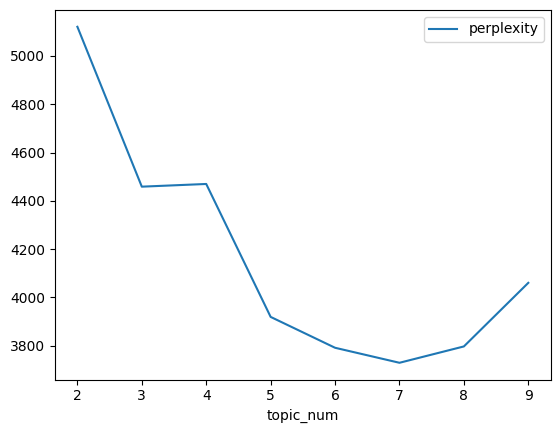

In [143]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

2024-04-23 12:02:27,005 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:27,006 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:27,007 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:27,007 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:27,008 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:27,008 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:02:27,009 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

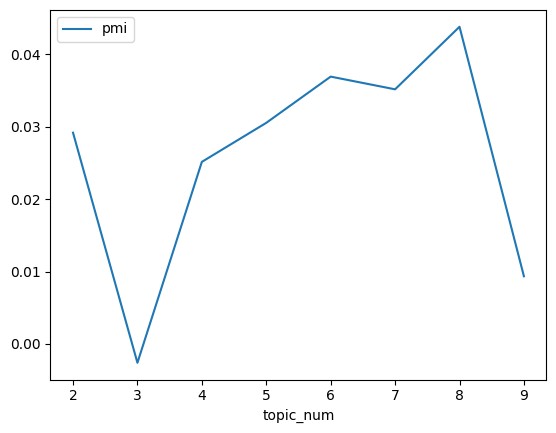

In [144]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 5 之後都不錯，coherence 最高則是 8

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [145]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2024-04-23 12:02:27,118 : INFO : using symmetric alpha at 0.125
2024-04-23 12:02:27,118 : INFO : using symmetric eta at 0.125
2024-04-23 12:02:27,120 : INFO : using serial LDA version on this node
2024-04-23 12:02:27,127 : INFO : running online (multi-pass) LDA training, 8 topics, 5 passes over the supplied corpus of 6531 documents, updating model once every 2000 documents, evaluating perplexity every 6531 documents, iterating 50x with a convergence threshold of 0.001000
2024-04-23 12:02:27,128 : INFO : PROGRESS: pass 0, at document #2000/6531
2024-04-23 12:02:27,654 : INFO : merging changes from 2000 documents into a model of 6531 documents
2024-04-23 12:02:27,658 : INFO : topic #0 (0.125): 0.008*"表示" + 0.007*"以色列" + 0.007*"今天" + 0.007*"美國" + 0.005*"報導" + 0.005*"俄羅斯" + 0.004*"烏克蘭" + 0.003*"巴勒斯坦" + 0.003*"球隊" + 0.003*"戰爭"
2024-04-23 12:02:27,658 : INFO : topic #3 (0.125): 0.008*"今天" + 0.007*"表示" + 0.005*"球員" + 0.005*"大谷" + 0.004*"美國" + 0.004*"比賽" + 0.004*"球迷" + 0.003*"聯盟" + 0.003*"以色列"

In [50]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

/opt/anaconda3/envs/py38_sma/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.110739  0.188169       1        1  21.057720
7      0.085308  0.122750       2        1  16.994200
6      0.213475 -0.041810       3        1  13.748066
1     -0.106838 -0.200767       4        1  13.741080
4      0.084747  0.161958       5        1  11.023525
2      0.262909 -0.136778       6        1  10.690201
5     -0.235772 -0.047290       7        1   6.770984
3     -0.193089 -0.046232       8        1   5.974224, topic_info=     Term         Freq        Total Category  logprob  loglift
6990   香港  4340.000000  4340.000000  Default  30.0000  30.0000
4393   億元  4449.000000  4449.000000  Default  29.0000  29.0000
1283   營收  2808.000000  2808.000000  Default  28.0000  28.0000
2648   中國  9093.000000  9093.000000  Default  27.0000  27.0000
687    成長  3132.000000  3132.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
785    運動   164.036341   537.509415   Topic8  -6.0185   1.6309
9149   北京   176.766684  1265.978685   Topic8  -5.9438   0.8489
6267   大陸   200.092081  5376.486273   Topic8  -5.8198  -0.4733
1484   今天   190.726984  3029.732648   Topic8  -5.8678   0.0523
161    發展   176.826721  2258.216335   Topic8  -5.9434   0.2706

[615 rows x 6 columns], token_table=       Topic      Freq Term
term                       
2008       1  0.193188   一名
2008       2  0.027598   一名
2008       4  0.077275   一名
2008       5  0.003680   一名
2008       7  0.688118   一名
...      ...       ...  ...
2860       8  0.759844   體育
19815      2  0.994791   高合
17439      2  0.004499   高息
17439      3  0.994385   高息
14200      8  0.979564   黃岩

[1634 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 7, 2, 5, 3, 6, 4])

可以看到(7,8)、(3,6)和(2,5)很相近，試試看跑5個主題

In [146]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-04-23 12:05:07,254 : INFO : using symmetric alpha at 0.2
2024-04-23 12:05:07,256 : INFO : using symmetric eta at 0.2
2024-04-23 12:05:07,259 : INFO : using serial LDA version on this node
2024-04-23 12:05:07,266 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 6531 documents, updating model once every 2000 documents, evaluating perplexity every 6531 documents, iterating 50x with a convergence threshold of 0.001000
2024-04-23 12:05:07,268 : INFO : PROGRESS: pass 0, at document #2000/6531
2024-04-23 12:05:07,802 : INFO : merging changes from 2000 documents into a model of 6531 documents
2024-04-23 12:05:07,805 : INFO : topic #0 (0.200): 0.008*"表示" + 0.007*"今天" + 0.006*"美國" + 0.005*"以色列" + 0.005*"報導" + 0.005*"烏克蘭" + 0.005*"俄羅斯" + 0.004*"球隊" + 0.003*"戰爭" + 0.003*"去年"
2024-04-23 12:05:07,805 : INFO : topic #1 (0.200): 0.007*"今天" + 0.005*"去年" + 0.005*"球員" + 0.005*"表示" + 0.005*"今年" + 0.005*"美國" + 0.004*"球隊" + 0.004*"聯盟" + 0.003*"台灣" + 0.00

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.107157 -0.147625       1        1  26.782069
2     -0.266617  0.064987       2        1  21.630561
4     -0.131785 -0.103167       3        1  20.842863
1      0.119592  0.237112       4        1  17.191071
3      0.171653 -0.051307       5        1  13.553437, topic_info=     Term         Freq        Total Category  logprob  loglift
4393   億元  4879.000000  4879.000000  Default  30.0000  30.0000
1283   營收  2955.000000  2955.000000  Default  29.0000  29.0000
2648   中國  8849.000000  8849.000000  Default  28.0000  28.0000
1222   市場  4333.000000  4333.000000  Default  27.0000  27.0000
6990   香港  3462.000000  3462.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
206    認為   421.615068  2070.914606   Topic5  -5.8937   0.4069
9149   北京   357.480794  1202.800423   Topic5  -6.0587   0.7852
9494  人民幣   363.576765  1532.709039   Topic5  -6.0418   0.5597
1031   已經   341.878958  1546.067592   Topic5  -6.1033   0.4895
128    期間   302.578768  1213.951639   Topic5  -6.2254   0.6092

[426 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
11328      1  0.996056    一架
2569       4  0.998824   三分球
19379      5  0.985155    三無
15713      1  0.016531  上市公司
15713      2  0.079347  上市公司
...      ...       ...   ...
19815      1  0.994159    高合
19815      3  0.005585    高合
3899       4  0.040291    高校
3899       5  0.956900    高校
15603      2  0.990828    點收

[964 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

替換主題數跑看看，可以看出最佳參數的數字和人類判斷的不一定會相符，所以為了更好的觀察文本中的資訊，逐步、循環的調整是很重要的

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [51]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.8` 可正常執行

In [53]:
import guidedlda

In [54]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一中', '一圈', '一壘手', '一定', '一起', '上季', '下滑', '不在', '不斷', '不算')

In [55]:
word2id = dictionary.token2id

In [74]:
seed_topic_list = [
    ["大谷", "春訓", "聯盟", "先發", "道奇"],
    ["股票", "投資", "外資", "利率", "基金"],
    ["台積電", "半導體", "科技", "鴻海", "電動車"],
    ["中國", "兩岸", "習近平", "政府", "外交"],
    ["全球", "美國", "國際", "世界", "日本"]
]

In [75]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [76]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [77]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-04-15 04:08:07,337 : INFO : n_documents: 6531
2024-04-15 04:08:07,338 : INFO : vocab_size: 19932
2024-04-15 04:08:07,340 : INFO : n_words: 1128398
2024-04-15 04:08:07,341 : INFO : n_topics: 6
2024-04-15 04:08:07,343 : INFO : n_iter: 100
2024-04-15 04:08:12,321 : INFO : <0> log likelihood: -12285099
2024-04-15 04:08:13,195 : INFO : <20> log likelihood: -9618869
2024-04-15 04:08:14,032 : INFO : <40> log likelihood: -9540600
2024-04-15 04:08:14,865 : INFO : <60> log likelihood: -9518862
2024-04-15 04:08:15,696 : INFO : <80> log likelihood: -9509815
2024-04-15 04:08:16,525 : INFO : <99> log likelihood: -9504992


In [79]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 今天 球員 比賽 聯盟 球隊 球迷 今年 去年 選手 表示
Topic 1: 市場 指數 投資 台股 投資人 上漲 股價 預期 表現 億元
Topic 2: 億元 營收 今年 成長 去年 市場 公司 需求 產品 持續
Topic 3: 中國 大陸 經濟 發展 香港 報導 台灣 表示 企業 國家
Topic 4: 美國 表示 總統 俄羅斯 報導 烏克蘭 以色列 拜登 今天 國家
Topic 5: 表示 報導 網友 香港 日本 萬元 影片 發現 已經 旅遊


/opt/anaconda3/envs/py38_sma/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.245685 -0.028676       1        1  18.663582
3      0.020675 -0.187939       2        1  17.605388
5      0.129803  0.041963       3        1  16.555546
1     -0.218459  0.059895       4        1  16.487771
0      0.122567  0.254648       5        1  15.943017
4      0.191100 -0.139891       6        1  14.744696, topic_info=     Term         Freq        Total Category  logprob  loglift
2648   中國  7105.000000  7105.000000  Default  30.0000  30.0000
1283   營收  2577.000000  2577.000000  Default  29.0000  29.0000
6267   大陸  3877.000000  3877.000000  Default  28.0000  28.0000
1307   美國  4792.000000  4792.000000  Default  27.0000  27.0000
4393   億元  3954.000000  3954.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
40     去年   516.431215  4561.250414   Topic6  -5.7751  -0.2641
321    包括   431.526371  2017.925066   Topic6  -5.9547   0.3718
106    提供   414.545402  1777.175954   Topic6  -5.9948   0.4587
1639   計畫   394.567792   924.075571   Topic6  -6.0442   1.0633
224    進行   391.571151  1972.967833   Topic6  -6.0519   0.2972

[447 rows x 6 columns], token_table=       Topic      Freq Term
term                       
2008       2  0.004836   一名
2008       3  0.770481   一名
2008       5  0.067699   一名
2008       6  0.157965   一名
2569       5  1.000948  三分球
...      ...       ...  ...
6990       2  0.604064   香港
6990       3  0.378169   香港
6990       5  0.017834   香港
13457      2  1.000447   駭客
17439      4  1.000875   高息

[882 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 2, 1, 5])

In [83]:
seed_topic_list = [
    ["大谷", "春訓", "聯盟", "先發", "道奇"],
    ['湖人', '太陽', '西區', "季後賽", "助攻", '籃板', '西區', '公鹿', '獨行俠', '詹姆斯', '勇士', "快艇", "熱火", "金塊"],
    ["股票", "投資", "外資", "利率", "基金", "台積電", "半導體", "科技", "鴻海", "電動車"],
    ["中國", "兩岸", "習近平", "政府", "外交"],
    ["大陸","網友","媒體","網路"],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [84]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-04-15 04:10:51,382 : INFO : n_documents: 6531
2024-04-15 04:10:51,382 : INFO : vocab_size: 19932
2024-04-15 04:10:51,382 : INFO : n_words: 1128398
2024-04-15 04:10:51,383 : INFO : n_topics: 6
2024-04-15 04:10:51,383 : INFO : n_iter: 100
2024-04-15 04:10:56,206 : INFO : <0> log likelihood: -12287703
2024-04-15 04:10:57,078 : INFO : <20> log likelihood: -9684225
2024-04-15 04:10:57,921 : INFO : <40> log likelihood: -9607259
2024-04-15 04:10:58,758 : INFO : <60> log likelihood: -9575128
2024-04-15 04:10:59,591 : INFO : <80> log likelihood: -9560023
2024-04-15 04:11:00,423 : INFO : <99> log likelihood: -9553029


In [85]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 台灣 表示 聯盟 日本 去年 今年 選手 球迷 今天 大谷
Topic 1: 今天 比賽 球員 勇士 球隊 戰績 籃板 數據 中華隊 表現
Topic 2: 億元 市場 成長 今年 營收 去年 預期 指數 投資 持續
Topic 3: 中國 美國 表示 國家 報導 總統 俄羅斯 大陸 烏克蘭 經濟
Topic 4: 香港 中國 報導 大陸 表示 人民幣 網友 指出 工作 春節
Topic 5: 公司 市場 企業 中國 表示 大陸 全球 發展 產品 技術


/opt/anaconda3/envs/py38_sma/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.154822 -0.229427       1        1  25.538241
3     -0.050897  0.170191       2        1  21.234159
4     -0.079482  0.211277       3        1  16.708674
5     -0.185725 -0.082663       4        1  16.093662
0      0.152035  0.019740       5        1  13.385680
1      0.318891 -0.089118       6        1   7.039584, topic_info=     Term         Freq        Total Category  logprob  loglift
1484   今天  3509.000000  3509.000000  Default  30.0000  30.0000
2648   中國  7105.000000  7105.000000  Default  29.0000  29.0000
1222   市場  4465.000000  4465.000000  Default  28.0000  28.0000
6990   香港  2186.000000  2186.000000  Default  27.0000  27.0000
2670   公司  3469.000000  3469.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
71     對手   249.489260   372.410106   Topic6  -5.7633   2.2530
1258   數據   414.145585  1585.065342   Topic6  -5.2565   1.3115
508    表現   394.187242  2371.453815   Topic6  -5.3059   0.8592
427    最後   313.355956   931.753763   Topic6  -5.5353   1.5639
22     交易   312.358038  1164.619289   Topic6  -5.5385   1.3376

[449 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2008      2  0.130563   一名
2008      3  0.714067   一名
2008      5  0.124116   一名
2008      6  0.032238   一名
986       6  1.001514   三分
...     ...       ...  ...
6990      6  0.016006   香港
2860      3  0.043012   體育
2860      4  0.007820   體育
2860      5  0.950177   體育
580       5  1.000704   龍隊

[894 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 6, 1, 2])

In [ ]:
# udn.loc[udn['artCatagory']=='兩岸', "content"].to_csv("tmp.csv")
udn.loc[udn['artCatagory']=='兩岸', "words"].to_csv("words.csv")
udn.loc[udn['artCatagory']=='股市', "words"].to_csv("words_stock.csv")


In [ ]:
udn.loc[udn['artCatagory']=='兩岸', "words"].explode().value_counts().to_csv("words_count.csv")
udn.loc[udn['artCatagory']=='股市', "words"].explode().value_counts().to_csv("words_count_stock.csv")

## 7. 主題分佈的應用，搭配其他文章資訊

In [147]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [148]:
topics_doc[100]

[(1, 0.9907832)]

In [149]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.02516275, 0.9710784 , 0.        , 0.        , 0.        ],
       [0.        , 0.99859673, 0.        , 0.        , 0.        ],
       [0.01092132, 0.26338083, 0.04868487, 0.61168492, 0.06532803],
       ...,
       [0.        , 0.        , 0.        , 0.99161923, 0.        ],
       [0.10244836, 0.        , 0.        , 0.89412725, 0.        ],
       [0.44532433, 0.        , 0.        , 0.55064744, 0.        ]])

In [150]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [151]:
udn['topic_label'].value_counts()

3    1774
1    1636
2    1252
5    1096
4     773
Name: topic_label, dtype: int64

In [152]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,由於過去幾年在季後的休賽期間總是在人員調動有令人吃驚的動作因此富邦被戲稱為季後賽王者沒想到這...,https://udn.com/news/story/122629/7746474,運動,2024-02-01 07:00:00,"[過去, 幾年, 季後的, 休賽, 期間, 總是, 人員, 調動, 令人吃驚, 動作, 富邦...",2
1,撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕造成骨裂傷勢賽季提前報銷球隊首度闖進季後挑...,https://udn.com/news/story/122629/7748599,運動,2024-02-05 12:00:00,"[撰文, 亞芳, 因骨裂, 影響, 賽季, 遭觸, 身球, 擊中, 手腕, 造成, 骨裂, ...",2
2,撰文鍾亞芳生涯中大半時間都在思索褪下球員身分後出路直到年收回出租房屋整理規畫後老婆對藝術有獨...,https://udn.com/news/story/122629/7748779,運動,2024-02-15 12:00:00,"[撰文, 亞芳, 生涯, 大半, 時間, 思索, 褪下, 球員, 身分, 出路, 直到, 收...",4
3,撰文鄧心瑜何恆佑是教練團公認訓練認真態度積極選手二軍火燙成績證明頗具實力無法兌現在一軍戰場是...,https://udn.com/news/story/122629/7748904,運動,2024-02-21 12:00:00,"[撰文, 鄧心, 何恆佑, 教練, 公認, 訓練, 認真, 態度, 積極, 選手, 軍火, ...",2
4,紐約尼克最近八連勝勝敗站上東區第三尼克進攻效率第六防守效率第七攻防兩端都是精英級別這可能是近...,https://udn.com/news/story/122629/7749189,運動,2024-02-02 07:00:00,"[紐約, 尼克, 最近, 連勝, 勝敗, 站上, 東區, 第三, 尼克, 進攻, 效率, 第...",2


In [153]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [154]:
udn['artDate'].dt.date

0       2024-02-01
1       2024-02-05
2       2024-02-15
3       2024-02-21
4       2024-02-02
           ...    
6526    2024-02-29
6527    2024-02-29
6528    2024-02-29
6529    2024-02-29
6530    2024-02-29
Name: artDate, Length: 6531, dtype: object

In [155]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-02-01  3              0.287719
            1              0.217544
            5              0.203509
            2              0.189474
            4              0.101754
                             ...   
2024-02-29  3              0.313070
            1              0.231003
            5              0.203647
            2              0.179331
            4              0.072948
Name: topic_label, Length: 145, dtype: float64

In [156]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
artDate,,,,,
2024-02-01,0.217544,0.189474,0.287719,0.101754,0.203509
2024-02-02,0.166667,0.192029,0.322464,0.101449,0.217391
2024-02-03,0.250000,0.285714,0.130952,0.190476,0.142857
2024-02-04,0.284810,0.284810,0.132911,0.107595,0.189873
2024-02-05,0.197232,0.152249,0.339100,0.134948,0.176471


2024-04-23 12:09:21,266 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,273 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,283 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,285 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,287 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,288 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,291 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

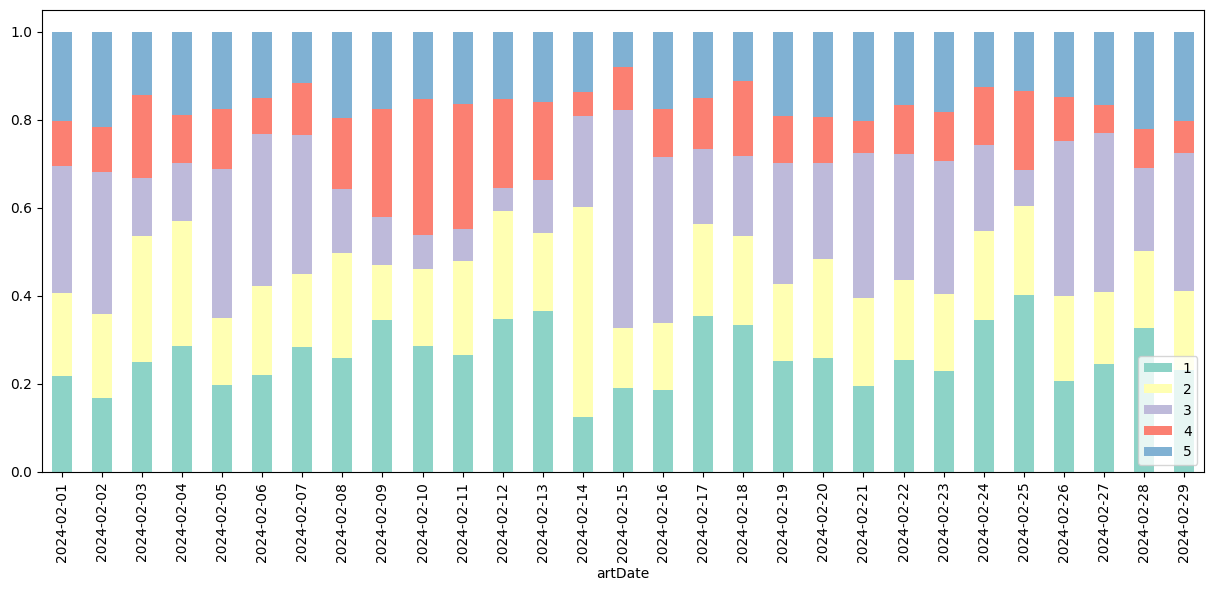

In [157]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題3（中國各產業市場）在 2/15、2/16 被討論的比例很高，可以作為後續探索的目標，<br>
大家可以像這樣，透過搭配文章的資訊（例如日期等），讓主題模型的結果做出更多的分析應用。